# Simple Gaussian Process Classification 9-10

### Methods
The Gaussian Process Classifier is a probabilistic, non-parametric machine learning method. It is particularly well-suited for classification tasks where the decision boundaries are complex and not easily defined by simple linear models. GPC models the data distribution using a Gaussian process, which allows it to capture non-linear relationships in the data.

We start of with a simpel RBF kernel.


### Workflow
- Gaussian Process Classifier:

    We will create an instance of the Gaussian Process Classifier with an RBF kernel and train it on the preprocessed data.
- Model Evaluation:

    We will evaluate the performance of the GPC model by measuring its accuracy and other relevant metrics.

In [ ]:
%%capture
!pip install cartopy
# !pip install gpflow

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import resample
sys.path.append("/Users/Lisanne/Documents/AI4ER/PhD/GPs")

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#merged_df = pd.read_pickle("/Users/Lisanne/Documents/AI4ER/PhD/GPs/data/processed/means2006.pkl")
mean_df = pd.read_pickle("/content/drive/MyDrive/ai4er/GPs/data/processed/ml_ready/coldwarmclass.pkl")

## Data preparation: recap from 1-4
Now work with full dataset

In [ ]:
merged_df = mean_df

# Count the occurrences of each class in the "WaterMass" column
class_counts = merged_df["WaterMass"].value_counts()

# Find the count of the third class
desired_class_count = class_counts[3]

# Create an empty DataFrame to store the balanced data
balanced_df = pd.DataFrame()

# Iterate over unique classes and balance the samples based on the count of the third class
for unique_class in merged_df["WaterMass"].unique():
    class_data = merged_df[merged_df["WaterMass"] == unique_class]
    class_balanced = resample(class_data, n_samples=desired_class_count, random_state=42)
    balanced_df = pd.concat([balanced_df, class_balanced])

In [ ]:
ref_latitude = 50
ref_longitude = -100

# Function to calculate angle between two points and the reference point
def calculate_angle(lat, lon):
  lat_rad, lon_rad = map(math.radians, [lat, lon])
  ref_lat_rad, ref_lon_rad = map(math.radians, [ref_latitude, ref_longitude])

  delta_lon = lon_rad - ref_lon_rad

  y = math.sin(delta_lon) * math.cos(lat_rad)
  x = math.cos(ref_lat_rad) * math.sin(lat_rad) - (math.sin(ref_lat_rad) * math.cos(lat_rad) * math.cos(delta_lon))

  angle_rad = math.atan2(y, x)
  angle_deg = math.degrees(angle_rad)
  return angle_deg

# Calculate angle for each point in the DataFrame
balanced_df['bearing'] = balanced_df.apply(lambda row: calculate_angle(row['latitude'], row['longitude']), axis=1)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Calculate distances from each point to the reference point
balanced_df['distance'] = haversine(ref_latitude, ref_longitude, balanced_df['latitude'], balanced_df['longitude'])

# Assuming 'balanced_df' already contains a 'month' column
balanced_df['seasonal_sin'] = np.sin(2 * np.pi * balanced_df['month'] / 12)

## Define training and test dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

n_clusters_per_region = 80

# Use KMeans for clustering within each region
kmeans_clusters = KMeans(n_clusters=n_clusters_per_region, n_init=n_clusters_per_region, random_state=7)
balanced_df['cluster'] = kmeans_clusters.fit_predict(balanced_df[['latitude', 'longitude']])

# Determine which clusters to assign to train, val, and test
cluster_indices = balanced_df['cluster'].unique()

# Assuming 'cluster' is the column containing cluster labels in balanced_df
clusters = balanced_df['cluster'].unique()

# Split clusters into training and validation sets
train_clusters, split_clusters = train_test_split(clusters, test_size=0.3, random_state=42)
val_clusters, test_clusters = train_test_split(split_clusters, test_size=0.4, random_state=42)

# Create training and validation datasets
train_dataset = balanced_df[balanced_df['cluster'].isin(train_clusters)]
val_dataset = balanced_df[balanced_df['cluster'].isin(val_clusters)]
test_dataset = balanced_df[balanced_df['cluster'].isin(test_clusters)]

# Verify the size of each dataset
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))

Train Dataset Size: 2497
Validation Dataset Size: 592
Test Dataset Size: 747


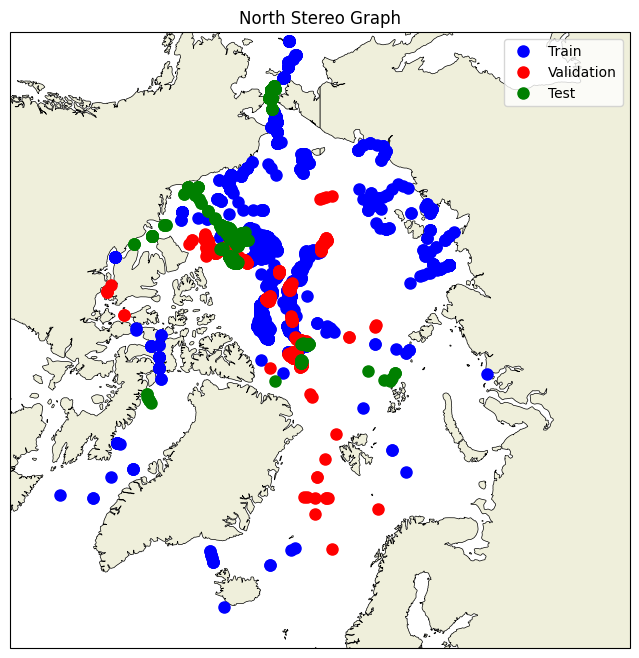

In [ ]:
# Create a north polar stereographic projection
projection = ccrs.NorthPolarStereo()

# Plot the datasets on a north stereo graph
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(8, 8))
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

# Add land contours
ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.5)

# Plot points for each dataset with different colors
ax.plot(train_dataset['longitude'], train_dataset['latitude'], 'bo', markersize=8, transform=ccrs.PlateCarree(), label='Train')
ax.plot(val_dataset['longitude'], val_dataset['latitude'], 'ro', markersize=8, transform=ccrs.PlateCarree(), label='Validation')
ax.plot(test_dataset['longitude'], test_dataset['latitude'], 'go', markersize=8, transform=ccrs.PlateCarree(), label='Test')

# Add legend and title
ax.legend()
ax.set_title('North Stereo Graph')

# Show the plot
plt.show()

# Step 9: Scaling


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf

# List of feature names
feature_names = ['distance', 'bearing', 'depth', 'seasonal_sin']

# Extract features and target variable from train_dataset
X_train_dataset = train_dataset[feature_names]
y_train_dataset = train_dataset['WaterMass']

# Extract features and target variable from val_dataset
X_val_dataset = val_dataset[feature_names]
y_val_dataset = val_dataset['WaterMass']

# Extract features and target variable from test_dataset
X_test_dataset = test_dataset[feature_names]
y_test_dataset = test_dataset['WaterMass']
y_latlon = test_dataset[['latitude', 'longitude', 'distance', 'bearing', 'depth', 'seasonal_sin']]

# Encode categorical labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded_dataset = label_encoder.fit_transform(y_train_dataset).reshape(-1, 1)
y_val_encoded_dataset = label_encoder.transform(y_val_dataset).reshape(-1, 1)
y_test_encoded_dataset = label_encoder.transform(y_test_dataset).reshape(-1, 1)

# Reshape without creating an additional dimension
y_train_encoded_dataset = y_train_encoded_dataset.reshape(-1)
y_val_encoded_dataset = y_val_encoded_dataset.reshape(-1)
y_test_encoded_dataset = y_test_encoded_dataset.reshape(-1)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled_dataset = scaler.fit_transform(X_train_dataset)
X_val_scaled_dataset = scaler.transform(X_val_dataset)
X_test_scaled_dataset = scaler.transform(X_test_dataset)

In [ ]:
# Create an RBF kernel with the different length scales
length_scale = [1.0, 0.1, 1, 0.1]

lengthscale_kernel = RBF(length_scale=length_scale)

# Create GaussianProcessClassifier with the current kernel
model_sklearn = GaussianProcessClassifier(kernel=lengthscale_kernel, n_restarts_optimizer=10)

# Fit the model to the training data
model_sklearn.fit(X_train_scaled_dataset, y_train_encoded_dataset)

GaussianProcessClassifier(kernel=RBF(length_scale=[1, 0.1, 1, 0.1]),
                          n_restarts_optimizer=10)

In [ ]:
# Make predictions on the validation set
predicted_classes = model_sklearn.predict(X_val_scaled_dataset)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val_encoded_dataset, predicted_classes)

# Print the accuracy for the current kernel
print(f"Validation Accuracy ({str(lengthscale_kernel)}): {accuracy * 100:.2f}%")

Validation Accuracy (RBF(length_scale=[1, 0.1, 1, 0.1])): 87.67%


# Step 10: Testing

In [ ]:
# Plot confusion matrix for the current kernel
conf_matrix = confusion_matrix(y_test_encoded_dataset, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix ({str(lengthscale_kernel)})')
plt.show()

ValueError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, mean_squared_error

# Classification Report
class_report = classification_report(y_test_encoded_dataset, predicted_classes)
print("Classification Report:")
print(class_report)

## Evaluation Loss Metrics

### Log Loss

Log Loss, also known as cross-entropy loss, is a commonly used metric for evaluating the performance of a classification model, especially in scenarios where the model predicts probabilities for each class. It is particularly well-suited for multiclass classification tasks. Log Loss penalizes models more heavily when they are confidently wrong, assigning higher penalties for predictions that diverge from the true class probabilities. This makes Log Loss sensitive to the uncertainty of the model, encouraging well-calibrated probability estimates.

**Use Case:**
- **Probabilistic Models:** Log Loss is valuable when your model provides probability estimates for each class. It encourages models to output probabilities that accurately reflect the likelihood of each class.

### Hamming Loss

Hamming Loss is a metric that measures the fraction of labels that are incorrectly predicted. It is especially relevant in multilabel classification scenarios, where each instance can belong to multiple classes simultaneously. Hamming Loss is suitable when dealing with imbalanced datasets and allows for a more nuanced evaluation of the model's performance.

**Use Case:**
- **Multilabel Classification:** When instances can belong to more than one class, Hamming Loss provides insights into the model's ability to predict the correct set of labels for each instance.
- **Imbalanced Datasets:** Hamming Loss is robust to class imbalances, making it useful in situations where certain classes may be underrepresented.

In summary, Log Loss is effective when assessing the probabilistic predictions of a model in multiclass classification, while Hamming Loss is valuable in scenarios involving multilabel classification and imbalanced datasets.


In [ ]:
from sklearn.metrics import log_loss

logloss = log_loss(y_test_encoded_dataset, model_sklearn.predict_proba(X_test_scaled_dataset))
print(f"Log Loss: {logloss}")

from sklearn.metrics import hamming_loss
hamming_loss_value = hamming_loss(y_test_encoded_dataset, predicted_classes)
print(f"Hamming Loss: {hamming_loss_value}")

## Imbalanced Dataset Evaluation Metrics

### Cohen's Kappa

Cohen's Kappa is a metric that quantifies the agreement between observed and expected classifications, while accounting for the possibility of agreement occurring by random chance. The formula for Cohen's Kappa is given by:

\[ \kappa = \frac{{P_o - P_e}}{{1 - P_e}} \]

where:
- \(P_o\) is the observed agreement.
- \(P_e\) is the expected agreement by chance.

Cohen's Kappa values range from -1 to 1, with 1 indicating perfect agreement, 0 indicating agreement equivalent to chance, and negative values suggesting less agreement than expected by chance.


### Matthews Correlation Coefficient (MCC)

The Matthews Correlation Coefficient (MCC) is a metric that combines information from the confusion matrix to assess the quality of binary and multiclass classifications. The formula for MCC is given by:

\[ MCC = \frac{{TP \times TN - FP \times FN}}{{\sqrt{{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}}} \]

where:
- \(TP\) is the number of true positives.
- \(TN\) is the number of true negatives.
- \(FP\) is the number of false positives.
- \(FN\) is the number of false negatives.

MCC values range from -1 to 1, with 1 indicating perfect prediction, 0 indicating no better than random prediction, and -1 indicating complete disagreement between prediction and truth.

In [ ]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test_encoded_dataset, predicted_classes)
print(f"Cohen's Kappa: {kappa}")

from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test_encoded_dataset, predicted_classes)
print(f"Matthews Correlation Coefficient: {mcc}")

# Result visualisation

In [ ]:
# Assuming y_latlon is your DataFrame
y_latlon_reset = y_latlon.reset_index(drop=True)

yhelp = pd.DataFrame(y_latlon_reset, columns=["longitude", "latitude", "depth", "seasonal_sin"])
y_test_df = pd.DataFrame(y_test_encoded_dataset, columns=["WaterMass"])
y_pred_df = pd.DataFrame(predicted_classes, columns=["pred_WM"])

# Concatenate the DataFrames
merged_results_df = pd.concat([y_test_df, y_pred_df, yhelp], axis=1)

merged_results_df.to_pickle("gp_final.pkl")

In [ ]:
# Create a polar projection centered on the North Pole
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-0))

# Set extent to focus on the Arctic region
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Create a scatter plot of latitude and longitude with different colors for each class
ax.stock_img()

# Define 4 distinct colors for the 4 classes
colors = ['blue', 'yellow', 'red', 'purple']

# Scatter plot for points where WaterMass and pred_WM do not agree (use red cross markers)
agreed_class = merged_results_df['WaterMass'] == merged_results_df['pred_WM']
disagreed_class = ~agreed_class

class_labels = merged_results_df['WaterMass'].unique()

# Define the order of legend entries #"SaltyWarm",
legend_order = ["NsCold", "SaltyCold", "NsWarm", "SaltyWarm", "Disagreed"]

for i, class_label in enumerate(class_labels):
    class_data = merged_results_df[merged_results_df['WaterMass'] == class_label]
    ax.scatter(class_data['longitude'], class_data['latitude'], c=colors[i], s=20, label=class_label, transform=ccrs.PlateCarree())

# Scatter plot for points where WaterMass and pred_WM do not agree (use red cross markers)
ax.scatter(merged_results_df[disagreed_class]['longitude'], merged_results_df[disagreed_class]['latitude'], c='black', marker='x', s=50, label='Disagreed', transform=ccrs.PlateCarree())

# Add title
ax.set_title("Arctic Water Body Classification at top 100m")

# Add coastlines
ax.add_feature(cfeature.COASTLINE)

# Add legend with specified order
ax.legend(legend_order)

# Add gridlines for latitude and longitude
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5)

custom_dark_gray = (0.2, 0.2, 0.2)  # RGB values for a dark gray color

# Add latitude and longitude labels next to the grid lines
#ax.text(-175, 60, '60°N', fontsize=12, transform=ccrs.PlateCarree(), color=custom_dark_gray)
ax.text(-175, 70, '70°N', fontsize=12, transform=ccrs.PlateCarree(), color=custom_dark_gray)
ax.text(-175, 80, '80°N', fontsize=12, transform=ccrs.PlateCarree(), color=custom_dark_gray)
ax.text(-175, 90, '90°N', fontsize=12, transform=ccrs.PlateCarree(), color=custom_dark_gray)

plt.show()

## Prediction grid visualisation

In [ ]:
# Generate latitude and longitude values
latitudes = list(range(60, 91))
longitudes = list(range(-180, 181))

# Create a mesh grid using the Cartesian product of latitudes and longitudes
coordinates = [(lat, lon) for lat in latitudes for lon in longitudes]

# Create a DataFrame
df = pd.DataFrame(coordinates, columns=['latitude', 'longitude'])

# Calculate angle for each point in the DataFrame
df['bearing'] = df.apply(lambda row: calculate_angle(row['latitude'], row['longitude']), axis=1)

# Calculate distances from each point to the reference point
df['distance'] = haversine(ref_latitude, ref_longitude, df['latitude'], df['longitude'])

df['month'] = 10
# Assuming 'balanced_df' already contains a 'month' column
df['seasonal_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['depth'] = 10


# Display the DataFrame
pred_df = (df[['distance', 'bearing', 'depth', 'seasonal_sin']])

pred_df_scaled = scaler.transform(pred_df)

# Predict water mass classes
predicted_classes_sept = model_sklearn.predict(pred_df_scaled)

# Decode the predicted classes back to original labels
predicted_classes_decoded_sept = label_encoder.inverse_transform(predicted_classes_sept)

# Create a DataFrame from the NumPy array with the same index as df
predictions_df = pd.DataFrame({'WaterMass': predicted_classes_decoded_sept}, index=df.index)

# Merge the two DataFrames based on the index
merged_df = pd.merge(df, predictions_df, left_index=True, right_index=True)

In [ ]:
## september
# Create a Cartopy map
fig, ax = plt.subplots(figsize=(5.3, 5.3), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-0)})

# Set extent to focus on the Arctic region
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Add coastlines
ax.add_feature(cfeature.COASTLINE)

# Define 4 distinct colors for the 4 classes
colors = {'NsCold': 'blue', 'SaltyCold': 'yellow', 'NsWarm': 'red', 'SaltyWarm': 'purple'}
colors = {'NsCold': 'lightslategray', 'SaltyCold': 'darkturquoise', 'NsWarm': 'lightcoral', 'SaltyWarm': 'sandybrown'}

# Scatter plot for each class
for wm_class, color in colors.items():
    class_data = merged_df[merged_df['WaterMass'] == wm_class]
    ax.scatter(class_data['longitude'], class_data['latitude'], c=color, s=20, label=wm_class, transform=ccrs.PlateCarree())

# Add legend
legend = ax.legend()
legend.get_frame().set_alpha(1.0)

# Add gridlines for latitude and longitude
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5)
# Add latitude and longitude labels next to the grid lines
ax.text(-175, 60, '60°N', fontsize=12, transform=ccrs.PlateCarree(), color='black')
ax.text(-175, 70, '70°N', fontsize=12, transform=ccrs.PlateCarree(),  color='black')
ax.text(-175, 80, '80°N', fontsize=12, transform=ccrs.PlateCarree(),  color='black')
ax.text(-175, 90, '90°N', fontsize=12, transform=ccrs.PlateCarree(),  color='black')

# Add title
#ax.set_title("Arctic Water Body Classification")

# Add land outlines and color the sea
ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1,  zorder=1)
ax.add_feature(cfeature.OCEAN, color='ghostwhite')

# Show the plot
plt.show()